In [26]:
#Qiskit Advocate Questions
#Questions related to Qiskit Ignis
%matplotlib inline
# Importing standard Qiskit libraries and configuring account
import numpy as np
from qiskit import QuantumCircuit, execute, Aer, IBMQ, QuantumRegister
from qiskit.compiler import transpile, assemble
import time

# Import Qiskit classes
import qiskit
from qiskit import QuantumRegister, QuantumCircuit, ClassicalRegister, Aer
from qiskit.providers.aer import noise
from qiskit.tools.visualization import plot_histogram

# Import measurement calibration functions
from qiskit.ignis.mitigation.measurement import (complete_meas_cal, tensored_meas_cal,
                                                 CompleteMeasFitter, TensoredMeasFitter)
from qiskit.tools.jupyter import *

# lib from Qiskit Aqua
from qiskit.transpiler import PassManager, CouplingMap
from qiskit.transpiler.passes import BasicSwap
from qiskit import Aer
from qiskit.visualization import plot_histogram
import matplotlib.pyplot as plt
from IPython import display


# Loading your IBM Q account(s)
provider = IBMQ.load_account()
q_simulator = Aer.get_backend('qasm_simulator')
u_simulator = Aer.get_backend('unitary_simulator')
s_simulator = Aer.get_backend('statevector_simulator')

ibmqfactory.load_account:WARNING:2020-08-10 21:18:45,894: Credentials are already in use. The existing account in the session will be replaced.


#1. Understanding the calibration matrix
<img src="questions/ignis_images/calib.png"> 
<h5>The image above shows the calibration matrix for two qubits. What kind of noise caused this?</h5>
<h5>Remember that a short decay time means more of the noise can be expected to have happened.</h5>
#options<br>
A. #Qubits in state <img src="http://latex.codecogs.com/svg.latex?\vert1\rangle" border="0"/> decay down to <img src="http://latex.codecogs.com/svg.latex?\vert0\rangle" border="0"/> before measurement. The decay times for both qubits are equal.<br>
B. #Qubits in state <img src="http://latex.codecogs.com/svg.latex?\vert0\rangle" border="0"/> decay down to <img src="http://latex.codecogs.com/svg.latex?\vert1\rangle" border="0"/> before measurement. The decay time for <samp>qr[0]</samp> is shorter than that for <samp>qr[1]</samp><br>
C. #Qubits in state <img src="http://latex.codecogs.com/svg.latex?\vert1\rangle" border="0"/> decay down to <img src="http://latex.codecogs.com/svg.latex?\vert0\rangle" border="0"/> before measurement. The decay time for <samp>qr[0]</samp> is longer than that for <samp>qr[1]</samp><br>
D. #Qubits in state <img src="http://latex.codecogs.com/svg.latex?\vert0\rangle" border="0"/> decay down to <img src="http://latex.codecogs.com/svg.latex?\vert1\rangle" border="0"/> before measurement. The decay time for <samp>qr[0]</samp> is longer than that for <samp>qr[1]</samp><br>
E. #Qubits in state <img src="http://latex.codecogs.com/svg.latex?\vert1\rangle" border="0"/> decay down to <img src="http://latex.codecogs.com/svg.latex?\vert0\rangle" border="0"/> before measurement. The decay time for <samp>qr[0]</samp> is shorter than that for <samp>qr[1]</samp><br>

['00', '01', '10', '11']
[[1. 0. 0. 0.]
 [0. 1. 0. 0.]
 [0. 0. 1. 0.]
 [0. 0. 0. 1.]]
[[1.    0.292 0.098 0.028]
 [0.    0.708 0.    0.057]
 [0.    0.    0.902 0.269]
 [0.    0.    0.    0.646]]


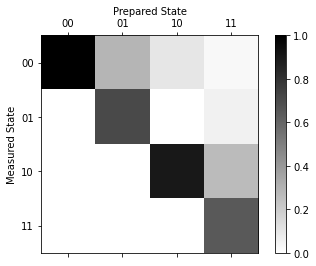

Average Measurement Fidelity: 0.814000
Average Measurement Fidelity of Q0: 0.954250


In [20]:
# Generate the calibration circuits
qr = qiskit.QuantumRegister(2)
qubit_list = [0,1]
meas_calibs, state_labels = complete_meas_cal(qubit_list=qubit_list, qr=qr, circlabel='mcal')
print(state_labels)

# Execute the calibration circuits without noise
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000)
cal_results = job.result()

# The calibration matrix without noise is the identity matrix
meas_fitter = CompleteMeasFitter(cal_results, state_labels, circlabel='mcal')
print(meas_fitter.cal_matrix)

# Generate a noise model for the 5 qubits

T2 = [1,1] # arbitrarily chosen T2 times
T1 = [30,100]
time_measure = 10 # arbitrarily chosen measurement time
noise_model = noise.NoiseModel()
for j in range(2):
    noise_model.add_quantum_error(noise.thermal_relaxation_error(T1[j], T2[j], time_measure) , "measure", [j])
    
"""
noise_model = noise.NoiseModel()
for qi in range(5):
    read_err = noise.errors.readout_error.ReadoutError([[0.9, 0.1],[0.25,0.75]])
    noise_model.add_readout_error(read_err, [qi])
"""    
    
# Execute the calibration circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
job = qiskit.execute(meas_calibs, backend=backend, shots=1000, noise_model=noise_model)
cal_results = job.result() 

# Calculate the calibration matrix with the noise model
meas_fitter = CompleteMeasFitter(cal_results, state_labels, qubit_list=qubit_list, circlabel='mcal')
print(meas_fitter.cal_matrix)

# Plot the calibration matrix
meas_fitter.plot_calibration()

# What is the measurement fidelity?
print("Average Measurement Fidelity: %f" % meas_fitter.readout_fidelity())

# What is the measurement fidelity of Q0?
print("Average Measurement Fidelity of Q0: %f" % meas_fitter.readout_fidelity(
    label_list = [['00','01'],['10','11']]))

In [35]:
# To calculate Quantum Volume, we test whether a certain condition is satisfied for random circuits 
#applied to successivly larger sets of qubits. 
#These can be made out of any qubits you have available. For example, the tutorial on quantum volume uses
#          qubit_lists = [[0,1,3],[0,1,3,5],[0,1,3,5,7],[0,1,3,5,7,10]]

# Let's extend the 2-qubit noise model from the previous question to 5 qubits.

#Import the qv function.
import qiskit.ignis.verification.quantum_volume as qv

n = 5
T1 =  [ j*20 for j in range(1,n+1) ]
T2 = [ 2*t1 for t1 in T1] # T2 times as large as they can be
time_measure = 10 # arbitrarily chosen measurement time
noise_model = noise.NoiseModel()
for j in range(n):
    noise_model.add_quantum_error(noise.thermal_relaxation_error(T1[j], T2[j], time_measure) , "measure", [j])
   
# Which of the following would be most sensible for calculating quantum volume, given the decay times on each qubit?
#1)  [[0,2,4],[0,2,3,4],[0,1,2,3,4]]
#2)  [[0,1,2],[0,1,2,3],[0,1,2,3,4]]
#3)  [[0,2,4],[0,1,2,4],[0,1,2,3,4]]
#4)  [[2,3,4],[1,2,3,4],[0,1,2,3,4]]
#5)  None of the above

#Qubit list
qubit_lists = [[2,3,4],[1,2,3,4],[0,1,2,3,4]]
ntrials = 50

qv_circs, qv_circs_nomeas = qv.qv_circuits(qubit_lists, ntrials)
#pass the first trial of the nomeas through the transpiler to illustrate the circuit
qv_circs_nomeas[0] = qiskit.compiler.transpile(qv_circs_nomeas[0], basis_gates=['u1','u2','u3','cx'])

#Simulate the ideal circuits
#The Unitary is an identity (with a global phase)
backend = qiskit.Aer.get_backend('statevector_simulator')
ideal_results = []
for trial in range(ntrials):
    print('Simulating trial %d'%trial)
    ideal_results.append(qiskit.execute(qv_circs_nomeas[trial], backend=backend, optimization_level=0).result())
    
#Next, load the ideal results into a quantum volume fitter:
qv_fitter = qv.QVFitter(qubit_lists=qubit_lists)
qv_fitter.add_statevectors(ideal_results)

#Simulate noisy circuits
backend = qiskit.Aer.get_backend('qasm_simulator')
basis_gates = ['u1','u2','u3','cx'] # use U,CX for now
shots = 1024
exp_results = []
for trial in range(ntrials):
    print('Running trial %d'%trial)
    exp_results.append(qiskit.execute(qv_circs[trial], 
                                      basis_gates=basis_gates, 
                                      backend=backend, 
                                      noise_model=noise_model, 
                                      backend_options={'max_parallel_experiments': 0}).result())
qv_fitter.add_data(exp_results)

Simulating trial 0
Simulating trial 1
Simulating trial 2
Simulating trial 3
Simulating trial 4
Simulating trial 5
Simulating trial 6
Simulating trial 7
Simulating trial 8
Simulating trial 9
Simulating trial 10
Simulating trial 11
Simulating trial 12
Simulating trial 13
Simulating trial 14
Simulating trial 15
Simulating trial 16
Simulating trial 17
Simulating trial 18
Simulating trial 19
Simulating trial 20
Simulating trial 21
Simulating trial 22
Simulating trial 23
Simulating trial 24
Simulating trial 25
Simulating trial 26
Simulating trial 27
Simulating trial 28
Simulating trial 29
Simulating trial 30
Simulating trial 31
Simulating trial 32
Simulating trial 33
Simulating trial 34
Simulating trial 35
Simulating trial 36
Simulating trial 37
Simulating trial 38
Simulating trial 39
Simulating trial 40
Simulating trial 41
Simulating trial 42
Simulating trial 43
Simulating trial 44
Simulating trial 45
Simulating trial 46
Simulating trial 47
Simulating trial 48
Simulating trial 49
Running tr

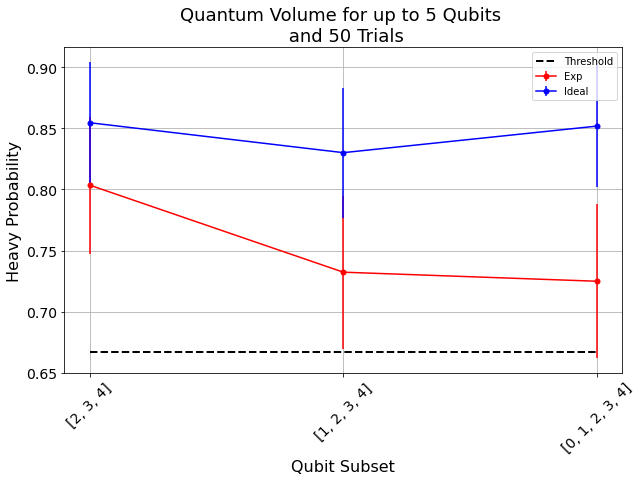

In [36]:
plt.figure(figsize=(10, 6))
ax = plt.gca()

# Plot the essence by calling plot_rb_data
qv_fitter.plot_qv_data(ax=ax, show_plt=False)

# Add title and label
ax.set_title('Quantum Volume for up to %d Qubits \n and %d Trials'%(len(qubit_lists[-1]), ntrials), fontsize=18)

plt.show()

In [37]:
qv_success_list = qv_fitter.qv_success()
qv_list = qv_fitter.ydata
for qidx, qubit_list in enumerate(qubit_lists):
    if qv_list[0][qidx]>2/3:
        if qv_success_list[qidx][0]:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (successful). Quantum volume %d"%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1],qv_fitter.quantum_volume()[qidx]))
        else:
            print("Width/depth %d greater than 2/3 (%f) with confidence %f (unsuccessful)."%
                  (len(qubit_list),qv_list[0][qidx],qv_success_list[qidx][1]))
    else:
        print("Width/depth %d less than 2/3 (unsuccessful)."%len(qubit_list))

Width/depth 3 greater than 2/3 (0.803574) with confidence 0.992589 (successful). Quantum volume 8
Width/depth 4 greater than 2/3 (0.732285) with confidence 0.852666 (unsuccessful).
Width/depth 5 greater than 2/3 (0.724863) with confidence 0.821597 (unsuccessful).


#3. Calculating quantum volume
<h5>To calculate the quantum volume, we test whether a certain condition is satisfied for random circuits 
applied to successivly larger sets of qubits. These can be made out of any qubits you have available. 
For example, the tutorial on quantum volume uses</h5>
<pre>
        qubit_lists = [[0,1,3],[0,1,3,5],[0,1,3,5,7],[0,1,3,5,7,10]]
</pre>
<h5>Let's extend the error model from before to 5 qubits.</h5>
<pre>
n = 5
T1 =  [ j*20e3 for j in range(1,n+1) ]
T2 = [ 2*t1 for t1 in T1] # T2 times as large as they can be
time_measure = 10e3 # arbitrarily chosen measurement time
noise_thermal = NoiseModel()
for j in range(n):
    noise_thermal.add_quantum_error( thermal_relaxation_error(T1[j], T2[j], time_measure) , "measure", [j])
</pre>

<h5>Which of the following would be most sensible for calculating quantum volume, given the decay times on each qubit?</h5>
<br>A. <samp>[[0,2,4],[0,2,3,4],[0,1,2,3,4]]</samp>
<br>B. <samp>[[0,1,2],[0,1,2,3],[0,1,2,3,4]]</samp>
<br>C. <samp>[[0,2,4],[0,1,2,4],[0,1,2,3,4]]</samp>
<br>D. <samp>[[2,3,4],[1,2,3,4],[0,1,2,3,4]]</samp>
<br>E. None of the above